In [39]:
# Imports for project
#Current MO, copy a project and see if it works just for funsies

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as pylab

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import measure, morphology
from skimage.measure import regionprops
#from skimage.filters import threshold_otsu
#from skimage.morphology import square, binary_opening

In [16]:
#Get directory for the dataset
rootdir = '..\SignatureExtraction\Dataset_sig'

#Initialize an array for the images to analyze
docs = []

#Loop through the folder and append files to array
for subdir, _, files in os.walk(rootdir):
    for file in files:
        #There is a .txt file inside of the dataset
        if(file.endswith('.txt')):
            continue
        else:
            docs.append(os.path.join(subdir, file))

#Loop for debugging
#for doc in docs:
#    print(doc)

In [98]:
"""
@ONLINE{hse,
    author = "Ahmet Özlü",
    title  = "Overlapped handwritten signature extraction from scanned documents",
    year   = "2018",
    url    = "https://github.com/ahmetozlu/signature_extractor"
}
"""

#Begin by defining the function where all signature extraction will take place
def signature_extraction(src_im):
    #Check if the input is a numpy array
    im = rgb2gray(src_im)
        
    #Threshold the image to ensure it's in binary
    im_t = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)[1]
    
    #TEST (the following is taken from the link above)
    
    #Connected component analysis (according to link)
    #These two lines are doing the connected component analysis. No idea what the mean is doing.
    #Here is the documentation for the .label() method, this is what really does it
    #https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label
    blobs = im_t > im_t.mean()
    blobs_labels = measure.label(blobs, background=0)
    
    #These are the default "constant parameters" that the author gives us to configure the threshold for what elements are considered
    #as too small or too large to be signatures. They are relative to the average connected component size
    #84
    #250
    #100
    #18
    
    #For small components
    constant_parameter_1 = 84
    constant_parameter_2 = 250
    constant_parameter_3 = 100
    
    #For large components
    constant_parameter_4 = 18     
    
    #This is the method that loops through every connected component and finds the largest one
    the_biggest_component = 0
    total_area = 0
    counter = 0
    average = 0.0
    for region in regionprops(blobs_labels):
        if (region.area > 10):
            total_area = total_area + region.area
            counter = counter + 1
        
        if (region.area >= 250):
            if (region.area > the_biggest_component):
                the_biggest_component = region.area
    
    #This computes the average size of components
    average = (total_area/counter)
    print("the_biggest_component: " + str(the_biggest_component))
    print("average: " + str(average))
    
    #This computes the threshold for elements too small
    a4_small_size_outliar_constant = ((average/constant_parameter_1)*constant_parameter_2)+constant_parameter_3
    print("a4_small_size_outliar_constant: " + str(a4_small_size_outliar_constant))
    
    #This compoutes the threshold for elements too large
    a4_big_size_outliar_constant = a4_small_size_outliar_constant*constant_parameter_4
    print("a4_big_size_outliar_constant: " + str(a4_big_size_outliar_constant))
    
    #This removed the small objects using the previous threshold
    pre_version = morphology.remove_small_objects(blobs_labels, a4_small_size_outliar_constant)
    
    #No idea what any of this is doing
    component_sizes = np.bincount(pre_version.ravel())
    too_small = component_sizes > (a4_big_size_outliar_constant)
    too_small_mask = too_small[pre_version]
    pre_version[too_small_mask] = 0
    
    #END TEST
    
    return pre_version

the_biggest_component: 5132
average: 84.54732313575526
a4_small_size_outliar_constant: 351.6289379040335
a4_big_size_outliar_constant: 6329.320882272603


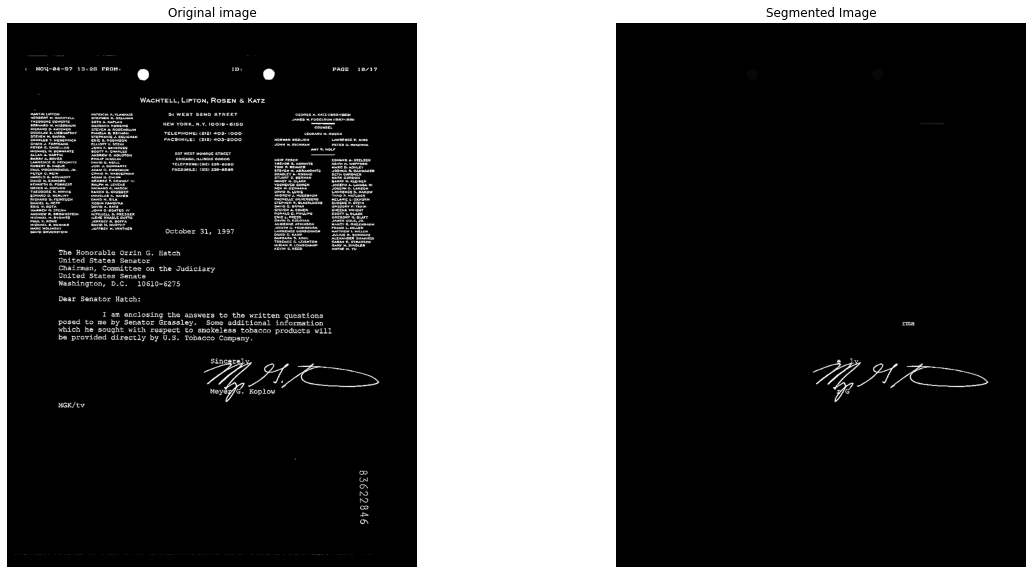

In [99]:
im = imread(docs[0])

im_test = signature_extraction(im)

fig, (axes1, axes2) = pylab.subplots(1, 2, figsize=(20, 10), sharex=True,sharey=True)
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Image')
pylab.show()